In [4]:
## Import Libraries
import en_core_web_sm
import pandas as pd
import nltk
import regex as re
import spacy
import numpy as np
import seaborn as sns
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

C:\Users\bathu\Anaconda3\lib\site-packages\spacy\util.py:707: UserWarning: [W095] Model 'en_core_web_sm' (2.3.1) requires spaCy >=2.3.0,<2.4.0 and is incompatible with the current version (3.0.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
# Open the combined dataset and create a column that counts the number of characters in the feedback.
df_traindata = pd.read_csv('C:/Users/bathu/Desktop/Machine Learning/Dataset/train/train_combined.txt', encoding= 'unicode_escape', delimiter= '\t', header=None,)

In [6]:
df_traindata.columns = ['feedback', 'sentiment', 'source']
df_traindata['text_length'] = df_traindata['feedback'].apply(len)
df_traindata.head()

,feedback,sentiment,source,text_length
0,Oh and I forgot to also mention the weird colo...,0,amazon,76
1,THAT one didn't work either.,0,amazon,28
2,Waste of 13 bucks.,0,amazon,18
3,"Product is useless, since it does not have eno...",0,amazon,124
4,None of the three sizes they sent with the hea...,0,amazon,73


In [7]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [8]:
df_traindata['feedback'] = df_traindata['feedback'].apply(clean_text)
df_traindata

,feedback,sentiment,source,text_length
0,Oh and I forgot to also mention the weird colo...,0,amazon,76
1,THAT one didn't work either.,0,amazon,28
2,Waste of 13 bucks.,0,amazon,18
3,"Product is useless, since it does not have eno...",0,amazon,124
4,None of the three sizes they sent with the hea...,0,amazon,73
5,Worst customer service.,0,amazon,23
6,The Ngage is still lacking in earbuds.,0,amazon,38
7,It always cuts out and makes a beep beep beep ...,0,amazon,76
8,the only VERY DISAPPOINTING thing was there wa...,0,amazon,67
9,Very disappointed in AccessoryOne.,0,amazon,34


In [9]:
from spacy.lang.en import English
parser = English()

In [10]:
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

In [11]:
import string
punctuations = string.punctuation

In [12]:
nlp = spacy.load("en_core_web_lg")

In [13]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    return mytokens

In [14]:
def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [15]:
%%time
df_traindata['short'] = df_traindata['feedback'].apply(convert_text)

Wall time: 14 s


In [16]:
df_traindata

,feedback,sentiment,source,text_length,short
0,Oh and I forgot to also mention the weird colo...,0,amazon,76,oh forgot mention weird color effect phone
1,THAT one didn't work either.,0,amazon,28,work
2,Waste of 13 bucks.,0,amazon,18,waste buck
3,"Product is useless, since it does not have eno...",0,amazon,124,product useless charge current charge cellphon...
4,None of the three sizes they sent with the hea...,0,amazon,73,size send headset stay ear
5,Worst customer service.,0,amazon,23,bad customer service
6,The Ngage is still lacking in earbuds.,0,amazon,38,Ngage lack earbud
7,It always cuts out and makes a beep beep beep ...,0,amazon,76,cut make beep beep beep sound say signal fail
8,the only VERY DISAPPOINTING thing was there wa...,0,amazon,67,disappointing thing speakerphone
9,Very disappointed in AccessoryOne.,0,amazon,34,disappointed AccessoryOne


In [17]:
df_traindata['text_short_length'] = df_traindata['short'].apply(len)
df_traindata

,feedback,sentiment,source,text_length,short,text_short_length
0,Oh and I forgot to also mention the weird colo...,0,amazon,76,oh forgot mention weird color effect phone,42
1,THAT one didn't work either.,0,amazon,28,work,4
2,Waste of 13 bucks.,0,amazon,18,waste buck,10
3,"Product is useless, since it does not have eno...",0,amazon,124,product useless charge current charge cellphon...,56
4,None of the three sizes they sent with the hea...,0,amazon,73,size send headset stay ear,26
5,Worst customer service.,0,amazon,23,bad customer service,20
6,The Ngage is still lacking in earbuds.,0,amazon,38,Ngage lack earbud,17
7,It always cuts out and makes a beep beep beep ...,0,amazon,76,cut make beep beep beep sound say signal fail,45
8,the only VERY DISAPPOINTING thing was there wa...,0,amazon,67,disappointing thing speakerphone,32
9,Very disappointed in AccessoryOne.,0,amazon,34,disappointed AccessoryOne,25


A negative feedback/sentiment is indicated by 0, while positive, 1.

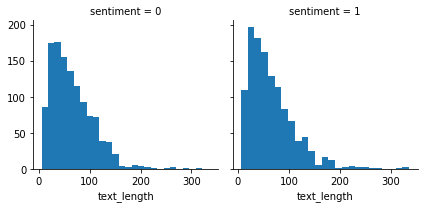

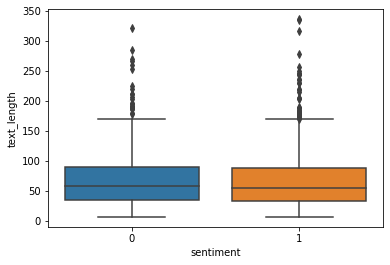

In [18]:
# Create plots to show distribution of text length vs. sentiment.
g = sns.FacetGrid(data=df_traindata, col='sentiment')
g.map(plt.hist, 'text_length', bins=25)
plt.show()
sns.boxplot(x='sentiment', y='text_length', data=df_traindata)
plt.show()

In [19]:
# Count the number of positive and negative reviews.
positive = df_traindata[(df_traindata['sentiment'] == 1)]
print('Number of positive reviews: {}'.format(positive.shape[0]))
negative = df_traindata[(df_traindata['sentiment'] == 0)]
print('Number of negative reviews: {}'.format(negative.shape[0]))

Number of positive reviews: 1200
Number of negative reviews: 1200


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(df_traindata['feedback'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [26]:
# Print the tokens and their corresponding counts.
print(vect.vocabulary_)

{'oh': 2703, 'and': 189, 'forgot': 1623, 'to': 4017, 'also': 166, 'mention': 2481, 'the': 3943, 'weird': 4375, 'color': 781, 'effect': 1299, 'it': 2124, 'has': 1840, 'on': 2717, 'your': 4499, 'phone': 2891, 'that': 3941, 'one': 2719, 'didn': 1111, 'work': 4452, 'either': 1308, 'waste': 4339, 'of': 2695, '13': 5, 'bucks': 542, 'product': 3041, 'is': 2120, 'useless': 4225, 'since': 3563, 'does': 1181, 'not': 2664, 'have': 1846, 'enough': 1352, 'charging': 686, 'current': 985, 'charge': 681, 'cellphones': 657, 'was': 4335, 'planning': 2920, 'use': 4221, 'with': 4431, 'none': 2654, 'three': 3979, 'sizes': 3579, 'they': 3959, 'sent': 3465, 'headset': 1858, 'would': 4468, 'stay': 3731, 'in': 2022, 'my': 2597, 'ears': 1275, 'worst': 4463, 'customer': 990, 'service': 3481, 'ngage': 2638, 'still': 3753, 'lacking': 2222, 'earbuds': 1266, 'always': 169, 'cuts': 997, 'out': 2753, 'makes': 2405, 'beep': 391, 'sound': 3661, 'then': 3954, 'says': 3391, 'signal': 3548, 'failed': 1465, 'only': 2723, 'v

In [27]:
# Transform the CountVectorizer object to create a document term matrix populated with token counts.
dtm_traindata = vect.transform(df_traindata['feedback'])
print(dtm_traindata)

  (0, 166)	1
  (0, 189)	1
  (0, 781)	1
  (0, 1299)	1
  (0, 1623)	1
  (0, 1840)	1
  (0, 2124)	1
  (0, 2481)	1
  (0, 2703)	1
  (0, 2717)	1
  (0, 2891)	1
  (0, 3943)	1
  (0, 4017)	1
  (0, 4375)	1
  (0, 4499)	1
  (1, 1111)	1
  (1, 1308)	1
  (1, 2719)	1
  (1, 3941)	1
  (1, 4452)	1
  (2, 5)	1
  (2, 542)	1
  (2, 2695)	1
  (2, 4339)	1
  (3, 657)	1
  :	:
  (2397, 2120)	1
  (2397, 2865)	1
  (2398, 189)	2
  (2398, 676)	1
  (2398, 1245)	1
  (2398, 2059)	1
  (2398, 2124)	1
  (2398, 2639)	1
  (2398, 2717)	2
  (2398, 2738)	1
  (2398, 2760)	1
  (2398, 2905)	1
  (2398, 3134)	1
  (2398, 3924)	1
  (2398, 3943)	3
  (2398, 4335)	1
  (2398, 4359)	1
  (2398, 4431)	1
  (2399, 189)	1
  (2399, 422)	1
  (2399, 811)	1
  (2399, 1753)	1
  (2399, 3481)	1
  (2399, 3943)	1
  (2399, 4335)	2


In [28]:
# Show the equivalent dataframe (i.e., dense matrix version).
pd.DataFrame(dtm_traindata.toarray(), columns=vect.get_feature_names())

,00,10,100,11,12,13,15,15g,15pm,17,...,youtube,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Build the multinomial Naive Bayes model and fit to the training dataset (i.e., traindata)
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(dtm_traindata, df_traindata['sentiment'])
    
# Determine training accuracy.
pred_traindata = mnb.predict(dtm_traindata)
print("Number of mislabeled points out of a total {} points: {}".format(dtm_traindata.shape[0],(df_traindata['sentiment'] != pred_traindata).sum()))
print("Training accuracy: {}".format((dtm_traindata.shape[0] - (df_traindata['sentiment'] != pred_traindata).sum()) / dtm_traindata.shape[0]))

Number of mislabeled points out of a total 2400 points: 126
Training accuracy: 0.9475


In [30]:
# Open the test dataset.
df_testdata = pd.read_csv('C:/Users/bathu/Desktop/Machine Learning/Dataset/test/test_combined.txt',encoding= 'unicode_escape', delimiter= '\t', header=None)
df_testdata.columns = ['feedback', 'sentiment','source']
df_testdata['text_length'] = df_testdata['feedback'].apply(len)
df_testdata.head()

,feedback,sentiment,source,text_length
0,It only recognizes the Phone as its storage de...,0,amazon,51
1,Disappointing accessory from a good manufacturer.,0,amazon,49
2,The one big drawback of the MP3 player is that...,0,amazon,149
3,This particular model would not work with my M...,0,amazon,67
4,If the two were seperated by a mere 5+ ft I st...,0,amazon,114


In [31]:
# Test and evaluate the model on the test dataset.
dtm_testdata = vect.transform(df_testdata['feedback'])
pred_testdata = mnb.predict(dtm_testdata)
print("Number of mislabeled points out of a total {} points: {}".format(dtm_testdata.shape[0],(df_testdata['sentiment'] != pred_testdata).sum()))
print("Model accuracy on testdata dataset: {}".format((dtm_testdata.shape[0] - (df_testdata['sentiment'] != pred_testdata).sum()) / dtm_testdata.shape[0]))

Number of mislabeled points out of a total 600 points: 107
Model accuracy on testdata dataset: 0.8216666666666667


In [32]:
# Split traindata into a training (70%) and test (30%) set.
from sklearn.model_selection import train_test_split
X_train_traindata, X_test_traindata, y_train_traindata, y_test_traindata = train_test_split(df_traindata['feedback'], df_traindata['sentiment'], test_size=0.3, random_state=101)
dtm_train_traindata = vect.transform(X_train_traindata)
dtm_test_traindata = vect.transform(X_test_traindata)
mnb.fit(dtm_train_traindata, y_train_traindata)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:

# Evaluate the training model on the test set.
pred_test_traindata = mnb.predict(dtm_test_traindata)
print("Number of mislabeled points out of a total {} points: {}".format(dtm_test_traindata.shape[0],(y_test_traindata != pred_test_traindata).sum()))

Number of mislabeled points out of a total 720 points: 135


In [34]:
# Verify with confusion and classification matrices.
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test_traindata, pred_test_traindata))
print(classification_report(y_test_traindata, pred_test_traindata))

[[303  63]
 [ 72 282]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       366
           1       0.82      0.80      0.81       354

    accuracy                           0.81       720
   macro avg       0.81      0.81      0.81       720
weighted avg       0.81      0.81      0.81       720



In [35]:

# Split testdata into a training (70%) and test (30%) set.
X_train_testdata, X_test_testdata, y_train_testdata, y_test_testdata = train_test_split(df_testdata['feedback'], df_testdata['sentiment'], test_size=0.3, random_state=101)
dtm_train_testdata = vect.transform(X_train_testdata)
dtm_test_testdata = vect.transform(X_test_testdata)
mnb.fit(dtm_train_testdata, y_train_testdata)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
# Evaluate the training model on the test set.
pred_test_testdata = mnb.predict(dtm_test_testdata)
print("Number of mislabeled points out of a total {} points: {}".format(dtm_test_testdata.shape[0],(y_test_testdata != pred_test_testdata).sum()))

Number of mislabeled points out of a total 180 points: 55


In [37]:

# Verify with confusion and classification matrices.
print(confusion_matrix(y_test_testdata, pred_test_testdata))
print(classification_report(y_test_testdata, pred_test_testdata))

[[51 39]
 [16 74]]
              precision    recall  f1-score   support

           0       0.76      0.57      0.65        90
           1       0.65      0.82      0.73        90

    accuracy                           0.69       180
   macro avg       0.71      0.69      0.69       180
weighted avg       0.71      0.69      0.69       180



In [38]:
# Count the number of positive and negative testdata reviews.
testdata_positive = df_testdata[(df_testdata['sentiment'] == 1)]
print('Number of positive testdata reviews: {}'.format(testdata_positive.shape[0]))
testdata_negative = df_testdata[(df_testdata['sentiment'] == 0)]
print('Number of negative testdata reviews: {}'.format(testdata_negative.shape[0]))

Number of positive testdata reviews: 300
Number of negative testdata reviews: 300


In [39]:
# Conduct cross-validation on data using three folds.
from sklearn.model_selection import StratifiedKFold
X_test = dtm_testdata
y_test = df_testdata['sentiment']
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X_test, y_test):
    mnb.fit(X_test[train], y_test[train])
    pred_test_strat = mnb.predict(X_test[test])
    print("Number of mislabeled points out of a total {} points: {}".format(X_test[test].shape[0],(y_test[test] != pred_test_strat).sum()))
    print(classification_report(y_test[test], pred_test_strat))
    print('\n')

Number of mislabeled points out of a total 200 points: 54
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       100
           1       0.76      0.67      0.71       100

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200



Number of mislabeled points out of a total 200 points: 92
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       100
           1       0.54      0.50      0.52       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200



Number of mislabeled points out of a total 200 points: 75
              precision    recall  f1-score   support

           0       0.64      0.56      0.60       100
           1       0.61      0.69      0.65       100

    


## Feature representation using Bag of Words

In [40]:
X = df_traindata['short']
Y = df_traindata['sentiment']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [41]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [42]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [53]:
pd.DataFrame(A.todense(), columns=counts.get_feature_names()).head()

,00,10,13,15,17,18th,3o,40min,42,44,...,young,youthful,youtube,yucky,yukon,yum,yummy,yun,zero,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [55]:
pd.DataFrame(B.todense(), columns=counts.get_feature_names()).head()

,00,10,13,15,17,18th,3o,40min,42,44,...,young,youthful,youtube,yucky,yukon,yum,yummy,yun,zero,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:

# create a classifier using SVC
classifier = SVC(kernel='linear')

In [57]:
# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [58]:
type(B)

scipy.sparse.csr.csr_matrix

In [60]:
# make predictions based on the test data
predictions = classifier.predict(B.todense())
predictions

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,

In [61]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7979


# Repeat using TF-IDF 
TF-IDF = Term Frequency - Inverse Document Frequency

In [62]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B.todense())

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.8125


# Modeling

This actually heps for geting the performance evaluation correctly.

In [63]:
# helper function to show results and charts
def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

In [65]:
results

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.797917,0.801653,0.798354,0.797911
1,TF-IDX,0.812500,0.812245,0.818930,0.812419
